# Benchmarking Numberlink Solvers

In [1]:
import sys
import os

# Add the `backend` folder to the path
sys.path.append(os.path.abspath("../backend/solvers"))

In [2]:
import time

from constraint_solver_path import ConstraintPathSolver
from pyco_solver_path import PycoPathSolver
from pyco_solver_edge import PycoEdgeSolver

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def run_constraint_path_solver(puzzle):
    solver = ConstraintPathSolver(puzzle)
    return solver.solve()


def run_pyco_path_solver(puzzle):
    solver = PycoPathSolver(puzzle)
    return solver.solve()


def run_pyco_edge_solver(puzzle):
    solver = PycoEdgeSolver(puzzle)
    return solver.solve()


solvers = {
    "ConstraintPathSolver": run_constraint_path_solver,
    "PycoPathSolver": run_pyco_path_solver,
    "PycoEdgeSolver": run_pyco_edge_solver,
}

In [4]:
def benchmark_solver(solver, puzzles):
    times = []
    for index in range(len(puzzles)):
        puzzle = puzzles[index]
        start_time = time.time()
        if solver(puzzle) is None:
            print(f"Failed to solve puzzle {index}")
            continue
        end_time = time.time()
        print(f"Solved puzzle {index} in {end_time - start_time} seconds")
        times.append(end_time - start_time)
    return times

In [5]:
import signal
import time
from contextlib import contextmanager

@contextmanager
def time_limit(seconds):
    def timeout_handler(signum, frame):
        raise TimeoutError("Function execution exceeded the time limit!")

    signal.signal(signal.SIGALRM, timeout_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

In [6]:
import json

with open("puzzles.json", "r") as f:
    puzzles = json.load(f)
    puzzles.sort(key=lambda x: x["dimension"])
puzzle_sizes = [puzzle["dimension"] for puzzle in puzzles]
puzzle_sizes

[4, 5, 6, 7, 8, 9, 10, 11]

In [7]:
from concurrent.futures import ThreadPoolExecutor, TimeoutError

MAX_RUNTIME = 1  # seconds

In [8]:
from tqdm import tqdm

results = {"Solver": [], "Puzzle Set": [], "Puzzle Number": [], "Time (s)": []}
NUM_PUZZLES_TO_SOLVE = 200


In [9]:
def benchmark(solver_name):
    solver = solvers[solver_name]
    for puzzle in puzzles:
        dimension = puzzle["dimension"]
        grids = puzzle["grids"]
        if len(grids) < NUM_PUZZLES_TO_SOLVE:
            print(
                f"Warning: Not enough puzzles for {solver_name} {dimension}x{dimension}"
            )
        grids = grids[:NUM_PUZZLES_TO_SOLVE]
        for i, grid in tqdm(
            enumerate(grids, 1),
            desc=f"{solver_name} {dimension}x{dimension}",
            total=len(grids),
        ):
            start_time = time.perf_counter_ns()
            with ThreadPoolExecutor(max_workers=1) as executor:
                future = executor.submit(solver, grid)
                try:
                    result = future.result(timeout=MAX_RUNTIME)
                    if result is None:
                        print(f"Failed to solve puzzle {i}")
                        continue
                except TimeoutError:
                    # print(f"Solver {solver_name} took too long on puzzle {i}")
                    time.sleep(2) # helps with the timeout?
                    break

            end_time = time.perf_counter_ns()
            results["Solver"].append(solver_name)
            results["Puzzle Set"].append(f"{dimension}x{dimension}")
            results["Puzzle Number"].append(i)
            results["Time (s)"].append(end_time - start_time)

print(solvers.keys())

dict_keys(['ConstraintPathSolver', 'PycoPathSolver', 'PycoEdgeSolver'])


In [10]:
benchmark("ConstraintPathSolver")

ConstraintPathSolver 11x11:   0%|          | 0/200 [00:19<?, ?it/s]


In [11]:
benchmark("PycoPathSolver")

PycoPathSolver 4x4:   0%|          | 0/200 [00:00<?, ?it/s]

PycoPathSolver 10x10:   0%|          | 0/200 [01:12<?, ?it/s]


KeyboardInterrupt: 

In [12]:
benchmark("PycoEdgeSolver")

PycoEdgeSolver 11x11: 100%|██████████| 200/200 [00:23<00:00,  8.60it/s]


In [13]:
df_results = pd.DataFrame(results)

In [14]:
df_results.to_csv("results.csv", index=False)

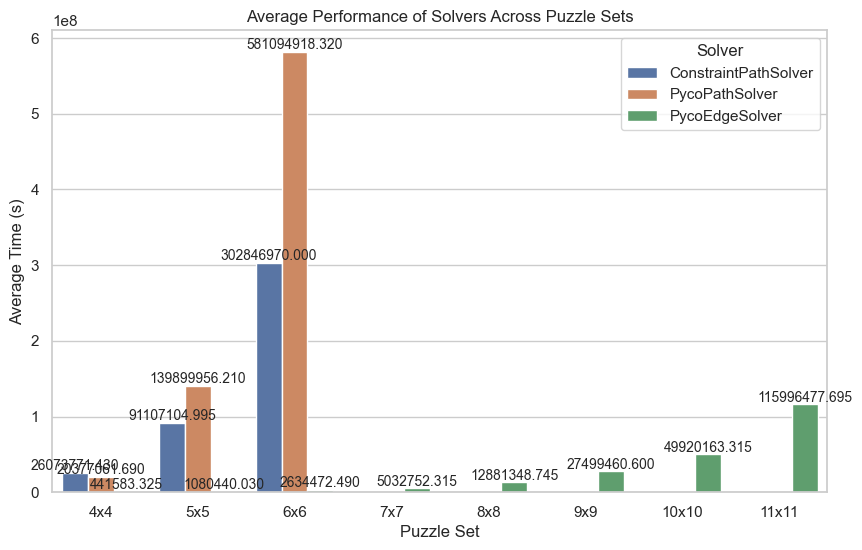

In [16]:
# Set style for the plot
sns.set(style="whitegrid")

# Create the bar plot without error bars
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x="Puzzle Set", y="Time (s)", hue="Solver", data=df_results, errorbar=None
)
plt.title("Average Performance of Solvers Across Puzzle Sets")
plt.xlabel("Puzzle Set")
plt.ylabel("Average Time (s)")
plt.legend(title="Solver")

# Add the values on top of the bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=10,
        )

plt.show()